In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy.interpolate import UnivariateSpline

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True

In [4]:
def my_obj(preds, train_data):
    labels = train_deata.get_label()
    

In [5]:
train = pd.read_csv('../data/public.train.csv')
train['is_train']= 1
test = pd.read_csv('../data/public.test.csv')
test['is_train']=0

train_len = train.shape[0]

df = pd.concat([train, test])

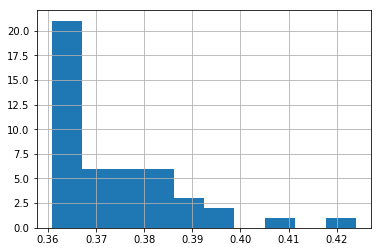

In [45]:
test[test['P_avg']<1]['ans'].hist()

In [6]:
df.rename(index=str, columns=rep_cols, inplace=True)

In [7]:
df.sort_values(by='ID',ascending=True, inplace=True)

In [8]:
df.head()

,ID,is_train,light_strength,P_A,P_B,P_C,y,P_avg,board_t,env_t,...,V_C,I_A,I_B,I_C,efficiency,efficiency_A,efficiency_B,efficiency_C,wind_direction,wind_speed
0,1,0,1,0.00,0.00,0.00,NaN,0.00,0.01,0.1,...,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0.1
1,9,0,13,909.72,148.05,1031.03,NaN,696.27,-19.33,-17.5,...,721,1.26,0.21,1.43,198.32,259.11,42.17,293.66,273,0.3
0,10,1,34,976.86,155.98,1087.50,1.437752,740.11,-19.14,-17.4,...,725,1.34,0.22,1.50,80.55,106.32,16.98,118.36,272,0.6
1,11,1,30,1128.40,172.08,1132.56,1.692575,811.01,-18.73,-17.3,...,726,1.55,0.24,1.56,99.90,139.00,21.20,139.51,275,0.8
2,12,1,41,1279.25,166.06,1310.40,1.975787,918.57,-17.54,-17.0,...,720,1.75,0.23,1.82,82.48,114.86,14.91,117.66,283,1.1


In [9]:
raw_feats = [x for x in df.columns.tolist() if x not in['ID','is_train','y']]

In [10]:
def get_ts_feature(df, f_name, prefix='', v_len = 25):
    v = df[f_name].values.tolist()
    # prev
    temp_list = []
    for i in range(df.shape[0]):
        temp_list.append(v[i-v_len:i][::-1])
    temp_df = pd.DataFrame(temp_list)
    temp_df.columns = [prefix+'prev_%d'%x for x in range(v_len)]
    temp_df['ID'] = df['ID'].values
    
    # succ
    temp_list = []
    for i in range(df.shape[0]):
        temp_list.append(v[i+1:i+v_len+1])
    temp_df2 = pd.DataFrame(temp_list)
    temp_df2.columns = [prefix+'succ_%d'%x for x in range(v_len)]
    temp_df2['ID'] = df['ID'].values
    
    temp_df = temp_df.merge(temp_df2, on='ID', how='left')
    return temp_df

In [11]:
#异常值处理
correct_dict = {
    'V_A':(480,60000),
    'V_B':(500,60000),
    'V_C':(500, 60000),
    'I_B':(0, 600),
    'I_C':(0, 30),
    'P_A':(0,10000),
    'P_B':(0,10000),
    'P_C':(0,10000),
    'P_avg':(0,10000)
}
cols = [c for c in df.columns.tolist() if c!='y' and c!='ID']
for c in correct_dict.keys():
    df[c+'_is_out_of_upper'] = (df[c]>correct_dict[c][1]).astype(np.int32)
    df[c+'_is_out_of_lower'] = (df[c]<correct_dict[c][0]).astype(np.int32)
    df.loc[df[c]>correct_dict[c][1],c]=np.nan
    df.loc[df[c]<correct_dict[c][0],c]=np.nan

In [12]:
def get_fake_feature(df, f_name):
    a = df['y']
    w=np.isnan(a)
    a[w]=0
    bt=df['ID']
    f=UnivariateSpline(bt,a,w=~w,k=4)
    x = df[['ID']]
    x['fake_'+f_name] = f(bt)
    return x

In [13]:
x = get_fake_feature(df, 'light_strength')
df = df.merge(x, on='ID', how='left')

x = get_fake_feature(df, 'env_t')
df = df.merge(x, on='ID', how='left')

x = get_fake_feature(df, 'y')
df = df.merge(x, on='ID', how='left')

x = get_fake_feature(df, 'board_t')
df = df.merge(x, on='ID', how='left')

/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
df[raw_feats].head()

,light_strength,P_A,P_B,P_C,P_avg,board_t,env_t,V_A,V_B,V_C,I_A,I_B,I_C,efficiency,efficiency_A,efficiency_B,efficiency_C,wind_direction,wind_speed
0,1,0.00,0.00,0.00,0.00,0.01,0.1,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0.1
1,13,909.72,148.05,1031.03,696.27,-19.33,-17.5,722.0,705.0,721.0,1.26,0.21,1.43,198.32,259.11,42.17,293.66,273,0.3
2,34,976.86,155.98,1087.50,740.11,-19.14,-17.4,729.0,709.0,725.0,1.34,0.22,1.50,80.55,106.32,16.98,118.36,272,0.6
3,30,1128.40,172.08,1132.56,811.01,-18.73,-17.3,728.0,717.0,726.0,1.55,0.24,1.56,99.90,139.00,21.20,139.51,275,0.8
4,41,1279.25,166.06,1310.40,918.57,-17.54,-17.0,731.0,722.0,720.0,1.75,0.23,1.82,82.48,114.86,14.91,117.66,283,1.1


In [16]:
for i in range(len(raw_feats)):
    for j in range(i,len(raw_feats)):
        df[raw_feats[i]+'_X_'+raw_feats[j]] = df[raw_feats[i]]*df[raw_feats[j]]

In [15]:
from sklearn.preprocessing import PolynomialFeatures
polynm = PolynomialFeatures(degree=2, interaction_only=True)
d = df[raw_feats].replace([np.inf, -np.inf], np.nan)
d.fillna(method='bfill',axis=0,inplace=True)
d.fillna(method='ffill',axis=0,inplace=True)
poly_feats = pd.DataFrame(polynm.fit_transform(d))
poly_feats['ID']=df['ID'].values
df = df.merge(poly_feats, on='ID', how='left')

In [21]:
poly_feats.shape

(17409, 192)

In [17]:
df.head()

,ID,is_train,light_strength,P_A,P_B,P_C,y,P_avg,board_t,env_t,...,efficiency_B_X_efficiency_B,efficiency_B_X_efficiency_C,efficiency_B_X_wind_direction,efficiency_B_X_wind_speed,efficiency_C_X_efficiency_C,efficiency_C_X_wind_direction,efficiency_C_X_wind_speed,wind_direction_X_wind_direction,wind_direction_X_wind_speed,wind_speed_X_wind_speed
0,1,0,1,0.00,0.00,0.00,0.000000,0.00,0.01,0.1,...,0.0000,0.0000,0.00,0.000,0.0000,0.00,0.000,1,0.1,0.01
1,9,0,13,909.72,148.05,1031.03,0.000000,696.27,-19.33,-17.5,...,1778.3089,12383.6422,11512.41,12.651,86236.1956,80169.18,88.098,74529,81.9,0.09
2,10,1,34,976.86,155.98,1087.50,1.437752,740.11,-19.14,-17.4,...,288.3204,2009.7528,4618.56,10.188,14009.0896,32193.92,71.016,73984,163.2,0.36
3,11,1,30,1128.40,172.08,1132.56,1.692575,811.01,-18.73,-17.3,...,449.4400,2957.6120,5830.00,16.960,19463.0401,38365.25,111.608,75625,220.0,0.64
4,12,1,41,1279.25,166.06,1310.40,1.975787,918.57,-17.54,-17.0,...,222.3081,1754.3106,4219.53,16.401,13843.8756,33297.78,129.426,80089,311.3,1.21


In [30]:
x = get_ts_feature(df, 'light_strength', 'ls')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'env_t', 'env_t')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'env_t', 'board_t')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'fake_y', 'fake_y')
df = df.merge(x, on='ID', how='left')

In [18]:
# target = ['P_A','P_avg','I_A','P_C','I_C','P_B','I_B']
# target_plus = [c+'_is_out_of_upper' for c in target]+[c+'_is_out_of_lower' for c in target]+target
# for c in target:
#     df['log_'+c] = np.log1p(df[c])

In [19]:
# 估算功率
df['predict_p_1'] = df['P_A']+df['P_B']+df['P_C']
df['predict_p_2'] = (df['P_A']*df['efficiency_A'] \
                   +df['P_B']*df['efficiency_B'] \
                   +df['P_C']*df['efficiency_C'])/36000

In [20]:
train = df[df['is_train']==1]
test = df[df['is_train']==0]

In [21]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'verbose': 0,
    'lambda_l1':1,
    'lambda_l2':0.1
}

In [22]:
predictor = [c for c in train.columns.tolist() if c not in['ID','y','is_train']]

In [23]:
len(predictor)

233

In [24]:
test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(test[predictor]))
        
#         train_set = lightgbm.Dataset(
#             tra[predictor],
#             np.log1p(tra['y'])
#         )

#         validation_set = lightgbm.Dataset(
#             val[predictor],
#             np.log1p(val['y'])
#         )

#         model = lightgbm.train(params, train_set, num_boost_round=5000,
#                               valid_sets= [validation_set],
#                               valid_names=['valid'],
#                               early_stopping_rounds=100,
#                                feval=my_val,
#                               verbose_eval=500)

#         val_preds[idx][val_idx] = np.expm1(model.predict(val[predictor]))
#         test_predicts.append(np.expm1(model.predict(test[predictor])))

Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0495188	valid's score: 0.817977
[1000]	valid's l2: 0.049135	valid's score: 0.818556
[1500]	valid's l2: 0.0490742	valid's score: 0.818648
Early stopping, best iteration is:
[1680]	valid's l2: 0.0490264	valid's score: 0.81872
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0123617	valid's score: 0.899942
[1000]	valid's l2: 0.0120187	valid's score: 0.901201
[1500]	valid's l2: 0.0119388	valid's score: 0.901498
[2000]	valid's l2: 0.0118928	valid's score: 0.901669
Early stopping, best iteration is:
[1955]	valid's l2: 0.0118904	valid's score: 0.901678
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.00904629	valid's score: 0.913149
Early stopping, best iteration is:
[446]	valid's l2: 0.00902163	valid's score: 0.913257
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0339906	valid's score: 0.844334
[1000]	valid

In [25]:
print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

local cv: 0.871783887846


In [26]:
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False).head(20)

P_A_X_P_avg     402522.974234
P_avg_X_I_A     286669.525988
I_A_X_I_C        21613.242754
P_A_X_I_B        18360.454521
predict_p_1      18222.924648
P_A              11241.384867
V_A_X_I_A         8252.489195
fake_env_t        4156.879491
P_C_X_I_A         3093.671467
P_avg_X_I_C       2535.629183
P_A_X_P_A         2534.696816
P_A_X_I_A         1669.269868
P_A_X_P_B         1642.717815
P_B_X_I_C         1588.420404
P_A_X_P_C         1494.770889
P_A_X_I_C         1379.372324
P_B_X_I_A         1109.970413
I_A                845.224211
fake_board_t       822.885811
I_A_X_I_A          785.838032
dtype: float64

In [27]:
test['ans'] = np.mean(test_predicts, axis=0)

/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
test[['ID','ans']].to_csv('../result/0810-8718-bagging.csv',header=False, index=False)

In [37]:
test['ans2']=test['ans']*1.1835

/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
test[['ID','ans2']].to_csv('../result/0810-8718-modified.csv',header=False, index=False)

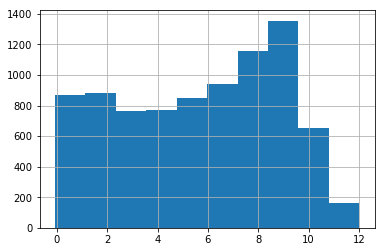

In [39]:
test['ans2'].hist()

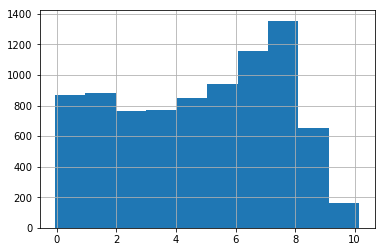

In [40]:
test['ans'].hist()

In [30]:
test['ans'].describe()

count    8409.000000
mean        4.811863
std         2.660021
min        -0.064294
25%         2.428454
50%         5.110464
75%         7.140176
max        10.153692
Name: ans, dtype: float64

In [36]:
test['ans2'].describe()

count    8409.000000
mean        5.620256
std         3.106905
min        -0.075095
25%         2.836434
50%         5.969022
75%         8.339726
max        11.859513
Name: ans2, dtype: float64

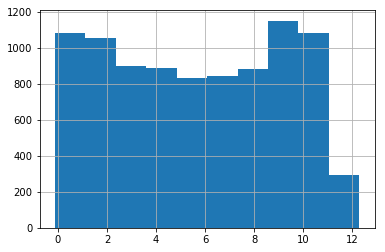

In [41]:
train['y'].hist()

In [32]:
train['y'].describe()

count    9000.000000
mean        5.695245
std         3.463744
min        -0.125144
25%         2.512812
50%         5.769032
75%         8.896220
max        12.288756
Name: y, dtype: float64